# "functional" Event Study in R, with `dplyr`

This is an example of leveraging some of the [functional programming](http://adv-r.had.co.nz/Functional-programming.html) tools in `R` with [`dplyr`](https://github.com/hadley/dplyr) and [`plyr`](http://plyr.had.co.nz/) (see for example the [split-apply-combine strategy](https://www.jstatsoft.org/article/view/v040i01) for analyzing data)

You can think of `dplyr` as `R`'s `data.frame` on steroids, which together with the the pipe (`%>%`) operator from [`magrittr`](https://github.com/smbache/magrittr) have created their own idiom for analyzing data and fitting models.

What we accomplish here is performing an entire event study, with just a handful lines of code, without a single `for` loop.

In [2]:
library(plyr)
library(dplyr)
library(ggplot2)
df = foreign::read.dta('family_event.dta')

#### First

Let's 

* Create one group variable `group` instead of having three dummies, and drop variables we won't use

* Define the estimation window (`estwin`) and event window (`evwin`), and add a variable indicating the window type (`window`), and keep only observations in these two windows

* Drop firms with missing observations

In [3]:
# Create one group variable
df$noheir = as.numeric(df$internal & !df$heir)
dummies = c("heir", "external", "noheir")
df$group = colnames(df[dummies])[max.col(df[dummies])] 

# Drop 
df = df[, !(names(df) %in% c(dummies, "internal", "announce_first_trade"))]

# Define and create
estwin = -250:-11
evwin = -10:20

# Add window and subset
df = df %>%
  filter(time %in% c(estwin, evwin)) %>%
  mutate(
    window = factor(time %in% estwin, labels = c("event", "estimation"))
    )

# Drop missing
complete = complete.cases(df)
drop = df$gvkey[!complete]
df = df[!(df$gvkey %in% drop), ]

The final data frame looks like

In [4]:
sample_n(df, 5)

,gvkey,date,ret,vwretd,time,group,window
53197,8551,19920916,0.01530612,-0.0008296593,-170,noheir,estimation
58421,9284,19960924,-0.009803922,7.267567e-05,-95,heir,estimation
51866,8365,19961004,0,0.01102261,-146,noheir,estimation
7677,2154,19890911,-0.01428571,-0.002690012,-162,noheir,estimation
10490,2625,19911230,-0.01935484,0.02030302,-59,external,estimation


#### Second

* Fit a linear model to each firm with data in the estimation window

we can do this easily by first filtering by rows in the `estimation` window, grouping the data by the unique firm identifier `gvkey` and calling `do`. The `.` placeholder refers to the data frame for which the function was called on (plenty of the cool features like these are attributable to [non standard evaluation](http://adv-r.had.co.nz/Computing-on-the-language.html))

In [5]:
models = df %>%
  filter(window == "estimation") %>%
  group_by(gvkey) %>%
  do(fit = lm(ret ~ vwretd, data = .))

We now have a list (`models`) with fields `gvkey` and `fit` (the `lm` object) containing all the `lm` models for the firms in `df`

```
> models
Source: local data frame [328 x 2]
Groups: <by row>

   gvkey     fit
   (dbl)   (chr)
1   1004 <S3:lm>
2   1094 <S3:lm>
3   1173 <S3:lm>
4   1239 <S3:lm>
5   1240 <S3:lm>
..   ...     ...
```

**Next** we use `adply` to apply `predict` on every model in the `model` list, and subtract this from the actual return `ret`

This way `predict` will fit the model in the `estimation` window and predict using the out of sample data in the `event` window, for each firm. `match()` is only used to pair each firm identifier in the `model` list with the list index (`1...`), and the last `rename` is only done since `adply` returns a data frame with a default named column.


In [6]:
df = df %>%
  group_by(gvkey, window) %>%
  do({
    adply(., 1, function(x)
      x$ret - predict(models$fit[[match(x$gvkey, models$gvkey)]], x))
  }) %>%
  rename(AR = `1`) %>%
  ungroup()

#### Third

We now have a complete dataset containing all the abnormal returns (the `AR` column added to `df`), which we can easily use to plot f.ex the ACAR over the entire event window:

ERROR: 

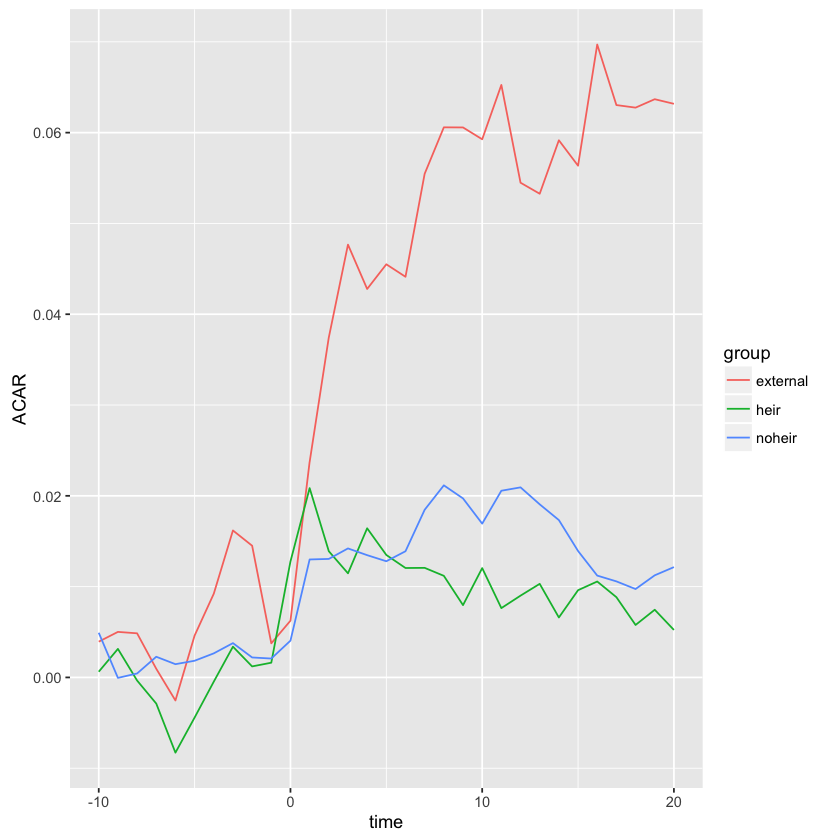

In [7]:
plotdf = df %>%
  filter(window %in% "event") %>% 
  group_by(gvkey) %>%
  mutate(CAR = cumsum(AR)) %>%
  group_by(group, time) %>%
  summarise(ACAR = mean(CAR))

ggplot(plotdf, aes(x = time, y = ACAR, color = group)) + geom_line()

**or** we could compute the statistics we are interested (let's first define the new event window from the assignemnt)

In [8]:
evwin = 0:3

The cumulative average abormal return for this new window, for the three different groups are:

In [9]:
df %>%
  filter(time %in% evwin) %>%
  group_by(group, gvkey) %>%
  summarise(CAR = cumsum(AR)[n()]) %>%
  summarise(CAR = mean(CAR)) 

,group,CAR
1,external,0.04391125
2,heir,0.009843262
3,noheir,0.01212793


The corresponding standard deviations are

In [10]:
df %>%
  filter(window %in% "estimation") %>%
  group_by(group, gvkey) %>%
  summarise(var = 1 / (length(estwin) - 2) * sum(AR ^ 2)) %>%
  summarise(Std_CAR = sqrt(length(evwin) * sum(var) / n() ^ 2))

,group,Std_CAR
1,external,0.0103576
2,heir,0.005781568
3,noheir,0.005131998


* If we where interested in the **unrelated **category we could do

In [11]:
df %>%
  filter(group != "heir") %>%
  filter(time %in% evwin) %>%
  group_by(gvkey) %>%
  summarise(CAR = cumsum(AR)[n()]) %>%
  summarise(CAR = mean(CAR)) 

,CAR
1,0.0179345


which has standard deviation

In [12]:
df %>%
  filter(group != "heir") %>%
  filter(window %in% "estimation") %>%
  group_by(gvkey) %>%
  summarise(var = 1 / (length(estwin) - 2) * sum(AR ^ 2)) %>%
  summarise(Std_CAR = sqrt(length(evwin) * sum(var) / n() ^ 2))

,Std_CAR
1,0.004601499


Giving a t-tstat of

In [13]:
0.0179345 / 0.004601499

[1] 3.897534